# Importação das bibliotecas

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

# Carregamento dos dataset de resultados

In [61]:
#usuario= "igorcapeletti"
usuario= "igorubuntu"

raiz= f"/home/{usuario}/github/tcc_eBPF_XDP/graficos"

#pasta de resultados gerais para programas eBPF: ----------------
#pasta_resultado_ebpf= 'resultados1'
#pasta_resultado_ebpf= 'resultados2'
pasta_resultado_ebpf= 'resultados3'
#pasta_resultado_ebpf= 'resultados4'
raiz_ebpf= f"/home/{usuario}/github/tcc_eBPF_XDP/experimentos/{pasta_resultado_ebpf}"


#pasta de resultados gerais para programas AF_XDP: ----------------
#pasta_resultado_af_xdp= 'resultados_af_xdp1'
#pasta_resultado_af_xdp= 'resultados_af_xdp2'
pasta_resultado_af_xdp= 'resultados_af_xdp3'
raiz_af_xdp= f"/home/{usuario}/github/tcc_eBPF_XDP/experimentos/{pasta_resultado_af_xdp}"


#carregamento dos arquivos CSV dos resultados dos programas eBPF e AF_XDP: ----------------
df_gerador_ebpf = pd.read_csv(f'{raiz_ebpf}/resultado_geral_gerador.csv', sep=',', engine='python')
df_gerador_af_xdp = pd.read_csv(f'{raiz_af_xdp}/resultado_geral_gerador.csv', sep=',', engine='python')

#normalizacao dos dados af_xdp
df_gerador_af_xdp['hook_ebpf']= df_gerador_af_xdp['hook_ebpf'].replace('xdpgeneric','af_xdp')

#concatenação dos dataframes referentes a cada analise (ebpf+af_xdp)
df_gerador= pd.concat([df_gerador_ebpf,df_gerador_af_xdp], sort = False)


In [62]:
lista_combined= [1,2,4,8]

lista_for= ['for_0_a_0','for_0_a_1','for_0_a_100','for_0_a_200','for_0_a_400','for_0_a_800','for_0_a_1600','for_0_a_3200','for_0_a_6400','for_0_a_12800']
lista_alias_for= ['0','1','100','200','400','800','1600','3200','6400','12800']

lista_hook_xdp= ['xdpgeneric','xdpdvr','af_xdp']

lista_pacotes= [64,128,256,512,1024,1500]
lista_alias_pacotes= ['64B','128B','256B','512B','1024B','1500B']

# Normalização dos datasets

In [63]:
#antes de executar isso, eliminar ultima coluna dos arquivos perf que estão em branco

#normalizacao para alterar o nome do algoritmo for_0_a_0 para base-line
#df_gerador['algoritmo']= df_gerador['algoritmo'].replace('for_0_a_0','base-line')
colunas= ['combined', 'algoritmo', 'packet_size', 'hook_ebpf', 'rx_packet_rate']
df_gerador= df_gerador[colunas]

df_gerador['hook_ebpf']= df_gerador['hook_ebpf'].replace('af_xdp','AF_XDP')
df_gerador['hook_ebpf']= df_gerador['hook_ebpf'].replace('xdpgeneric','Generic')
df_gerador['hook_ebpf']= df_gerador['hook_ebpf'].replace('xdpdrv','Native')

df_gerador['rx_packet_rate']= df_gerador['rx_packet_rate']*df_gerador['packet_size']
df_gerador['rx_packet_rate']= df_gerador['rx_packet_rate']/(1000000000)
df_gerador['rx_packet_rate']= df_gerador['rx_packet_rate']*8

for i,j in zip(lista_for,lista_alias_for):
       df_gerador['algoritmo']= df_gerador['algoritmo'].replace(f'{i}',f'{j}')

df_gerador['algoritmo']= df_gerador['algoritmo'].astype(int)
df_gerador = df_gerador.rename(columns={'hook_ebpf': 'Modo XDP'})

df_gerador

,combined,algoritmo,packet_size,Modo XDP,rx_packet_rate
0,4,0,64,Native,6.542567
1,2,0,64,Native,6.406294
2,2,0,1024,Native,9.824356
3,1,0,64,Generic,0.551655
4,4,0,512,Generic,9.638546
...,...,...,...,...,...
231,8,1600,512,AF_XDP,0.423856
232,8,1600,64,AF_XDP,0.050455
233,1,1600,1500,AF_XDP,1.563981
234,2,1600,1500,AF_XDP,1.496427


# Resultados do gerador

In [64]:
format_imagens= '.pdf'
#format_imagens= '.png'

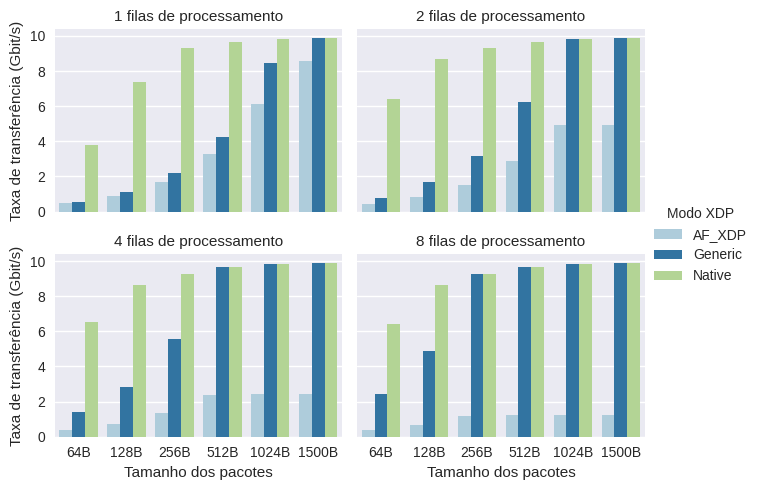

In [72]:
#Figura 17

algoritmo= 0

eixo_x= 'packet_size'
eixo_y= 'rx_packet_rate'
hue= 'Modo XDP'

plt.rc('figure', figsize=(5, 5))
df_gerador= df_gerador.sort_values(by=[eixo_x,hue,'Modo XDP'], ascending=True)       #ordena dados com os valores do eixo x

df= df_gerador.copy()
df= df[df.algoritmo == algoritmo]                #filtra por algoritmo especifico
df= df[[eixo_x, eixo_y, hue, 'combined']]

df['packet_size']= df['packet_size'].astype(str)
for i,j in zip(lista_pacotes,lista_alias_pacotes):
       df['packet_size']= df['packet_size'].replace(f'{i}',f'{j}')

df.index= range(len(df))
grafico = sns.catplot(
    data=df, x=eixo_x, y=eixo_y,
    col='combined', hue='Modo XDP',
    kind="bar", palette='Paired', col_wrap=2,
    height= 2.5, aspect=4/3
)
grafico.set_ylabels("Taxa de transferência (Gbit/s)")
grafico.set_xlabels("Tamanho dos pacotes")
grafico.set_titles("{col_name} filas de processamento")

grafico.savefig(f'{raiz}/vazao_{hue}_x_{eixo_x}@alg_{algoritmo}{format_imagens}')

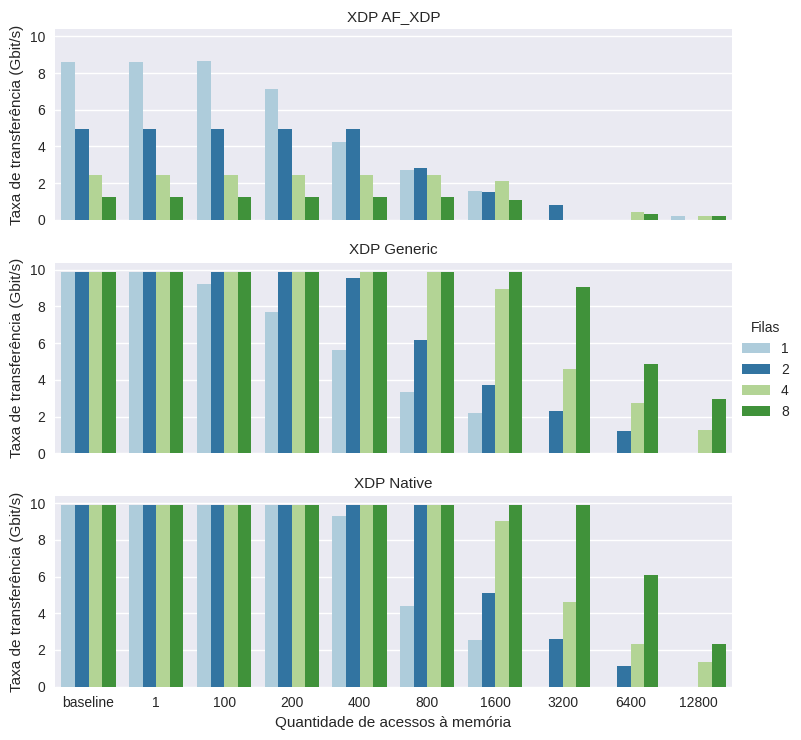

In [51]:
#Figura 18, 19 e 20

#packet_size= 64
#packet_size= 1024
packet_size= 1500

eixo_x= 'algoritmo'
eixo_y= 'rx_packet_rate'
hue= 'combined'

plt.rc('figure', figsize=(20, 5))
df_gerador= df_gerador.sort_values(by=[eixo_x,hue,'Modo XDP'], ascending=True)       #ordena dados com os valores do eixo x

df= df_gerador.copy()
df= df[df.packet_size == packet_size]            #filtra por tamanho de pacote especifico


df= df[[eixo_x, eixo_y, hue, 'Modo XDP']]
df = df.rename(columns={'combined': 'Filas'})
df['algoritmo']= df['algoritmo'].astype(str)
df['algoritmo']= df['algoritmo'].replace('0','baseline')


df.index= range(len(df))
#sns.set(font_scale= 1)
grafico = sns.catplot(
    data=df, x=eixo_x, y=eixo_y,
    col='Modo XDP', hue='Filas',
    kind="bar", palette='Paired', col_wrap=1,
    height= 2.5, aspect=6/2
)
grafico.set_ylabels("Taxa de transferência (Gbit/s)")
grafico.set_xlabels("Quantidade de acessos à memória")
grafico.set_titles("XDP {col_name}")


grafico.savefig(f'{raiz}/vazao_{hue}_x_{eixo_x}@{packet_size}{format_imagens}')

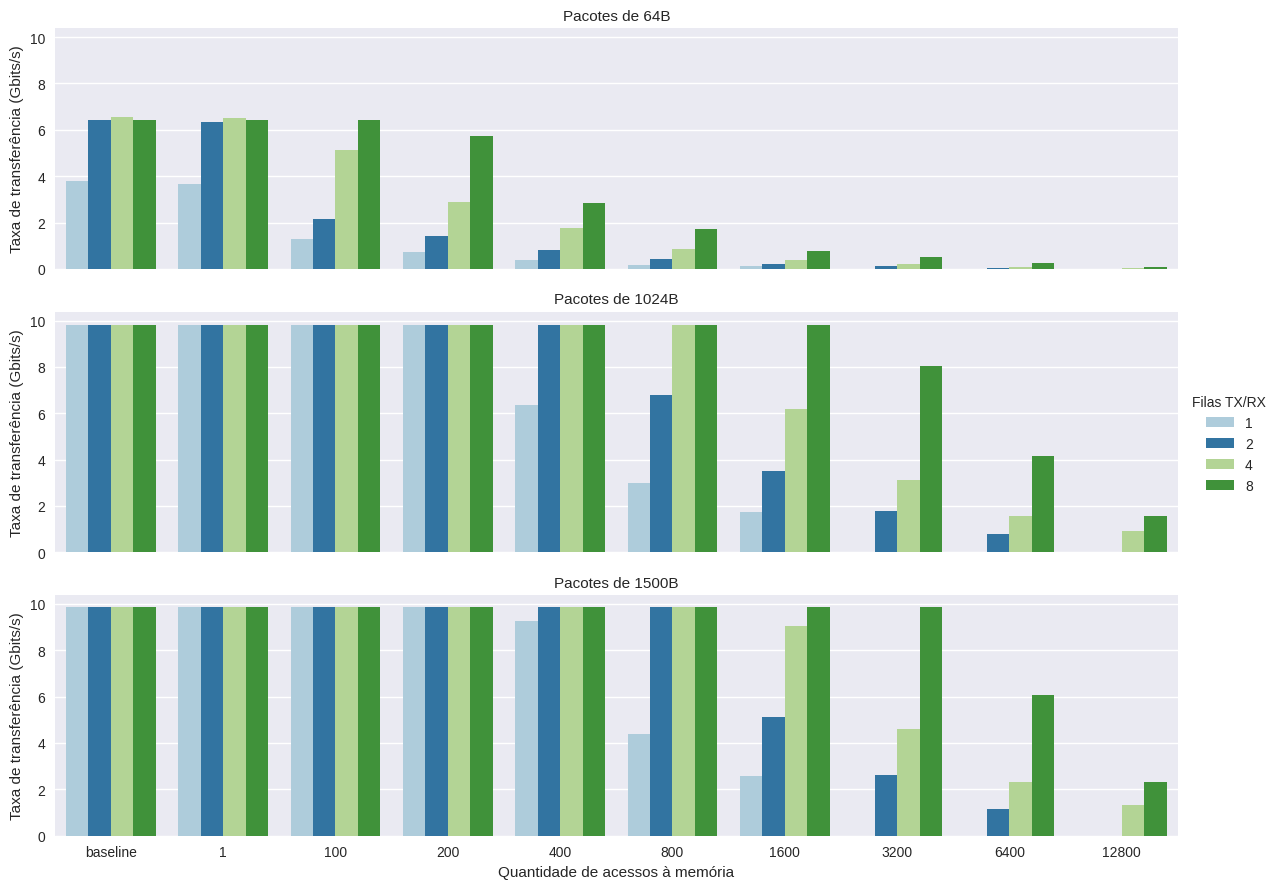

In [12]:
#Figura 21, 22 e 23

#hook_ebpf= 'AF_XDP'
#hook_ebpf= 'Generic'
hook_ebpf= 'Native'

eixo_x= 'algoritmo'
eixo_y= 'rx_packet_rate'
hue= 'combined'

plt.rc('figure', figsize=(20, 5))
df_gerador= df_gerador.sort_values(by=[eixo_x,hue], ascending=True)       #ordena dados com os valores do eixo x

df= df_gerador.copy()
df= pd.concat([df[df.packet_size == 64], df[df.packet_size == 1024], df[df.packet_size == 1500]], sort = False)
df= df[df.hook_ebpf == hook_ebpf]                          #filtra por modo XDP especifico

df= df[[eixo_x, eixo_y, hue, 'packet_size']]
df = df.rename(columns={'combined': 'Filas TX/RX'})
df['algoritmo']= df['algoritmo'].astype(str)
df['algoritmo']= df['algoritmo'].replace('0','baseline')


df.index= range(len(df))
grafico = sns.catplot(
    data=df, x=eixo_x, y=eixo_y,
    col='packet_size', hue='Filas TX/RX',
    kind="bar", palette='Paired', col_wrap=1,
    height= 3, aspect=12/3
)
grafico.set_ylabels("Taxa de transferência (Gbits/s)")
grafico.set_xlabels("Quantidade de acessos à memória")
grafico.set_titles("Pacotes de {col_name}B")


grafico.savefig(f'{raiz}/vazao_{hue}_x_{eixo_x}@hook_ebpf_{hook_ebpf}{format_imagens}')

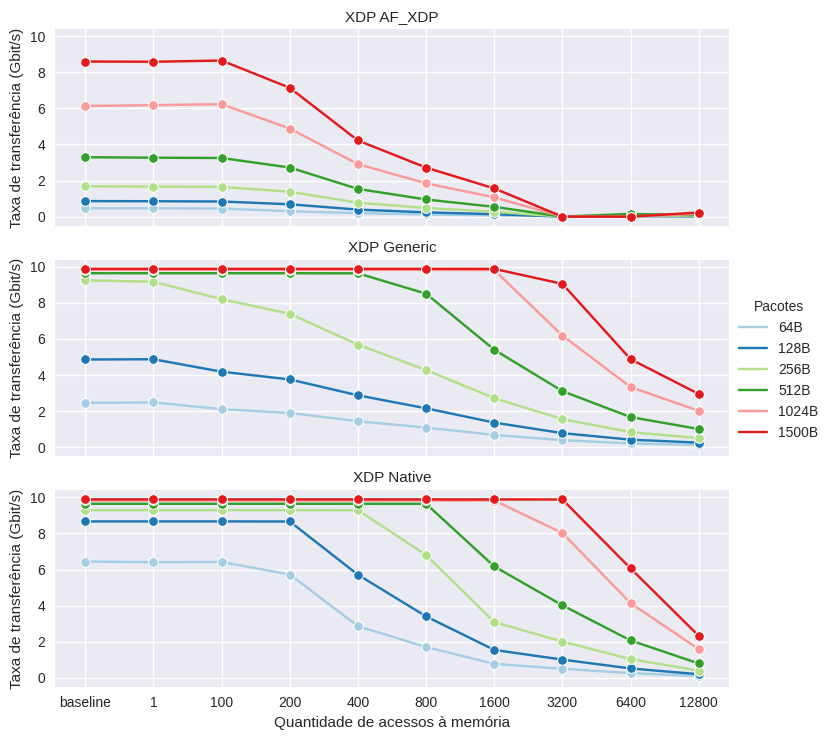

In [59]:
#Figura 24

eixo_x= 'algoritmo'
eixo_y= 'rx_packet_rate'
hue= 'packet_size'

plt.rc('figure', figsize=(20, 5))
df= df_gerador.copy()
df1= pd.concat([df[df['Modo XDP'] == 'Generic'], df[df['Modo XDP'] == 'Native']], sort = False)
df1= df1[df1.combined == 8]

df2= df[df.combined == 1]
df2= df2[df2['Modo XDP'] == 'AF_XDP']

df= pd.concat([df1, df2], sort = False)
df= df.sort_values(by=[eixo_x,hue,'Modo XDP'], ascending=True)       #ordena dados com os valores do eixo x

df = df.rename(columns={'packet_size': 'Pacotes'})
df['algoritmo']= df['algoritmo'].astype(str)
df['algoritmo']= df['algoritmo'].replace('0','baseline')

df['Pacotes']= df['Pacotes'].astype(str)
for i,j in zip(lista_pacotes,lista_alias_pacotes):
       df['Pacotes']= df['Pacotes'].replace(f'{i}',f'{j}')

df= df[[eixo_x, eixo_y, 'Pacotes', 'Modo XDP']]

df.index= range(len(df))
grafico = sns.relplot(
    data=df, x=eixo_x, y=eixo_y,
    col='Modo XDP', hue='Pacotes',
    kind="line", palette='Paired', col_wrap=1, marker='o',
    height= 2.5, aspect=6/2
)
grafico.set_ylabels("Taxa de transferência (Gbit/s)")
grafico.set_xlabels("Quantidade de acessos à memória")
grafico.set_titles("XDP {col_name}")


grafico.savefig(f'{raiz}/vazao_{hue}_x_{eixo_x}@combined_melhor_por_xdp{format_imagens}')